# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables #+ ['__MCDecayString__',]

Welcome to JupyROOT 6.26/14


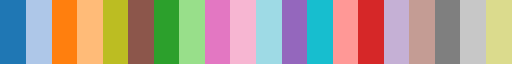

In [2]:
util.my_cmap

In [10]:
# cc = samples_sig['bkg_combinatorial'].query('ell_genMotherPDG * D_genMotherPDG==411*511')
# print(cc['__MCDecayString__'].iloc[4])

Content of MCParticle list
╰── Upsilon(4S) (300553)
    ├── B0 (511)
    │   ├── D- (-411)
    │   │   ├── K0 (311)
    │   │   │   ╰── K_L0 (130)
    │   │   │       ├╶╶ pi- (-211)
    │   │   │       ├╶╶ pi+ (211)
    │   │   │       │   ├╶╶ nu_mu (14)
    │   │   │       │   ├╶╶ mu+ (-13)
    │   │   │       │   │   ├╶╶ anti-nu_mu (-14)
    │   │   │       │   │   ├╶╶ nu_e (12)
    │   │   │       │   │   ╰╶╶ e+ (-11)
    │   │   │       │   ╰╶╶ e- (11)
    │   │   │       ╰╶╶ n0 (2112)
    │   │   ├── e- (11)
    │   │   │   ╰╶╶ gamma (22)
    │   │   ├── anti-nu_e (-12)
    │   │   ╰── gamma (22)
    │   ├── pi+ (211)
    │   │   ├╶╶ nu_mu (14)
    │   │   ╰╶╶ mu+ (-13)
    │   │       ├╶╶ anti-nu_mu (-14)
    │   │       ├╶╶ nu_e (12)
    │   │       ╰╶╶ e+ (-11)
    │   ├── rho+ (213)
    │   │   ├── pi+ (211)
    │   │   │   ╰╶╶ pi- (-211)
    │   │   ╰── pi0 (111)
    │   │       ├── gamma (22)
    │   │       ╰── gamma (22)
    │   │           ╰╶╶ gamma (22)
    │   ├── eta (

In [2]:
# 4S wrong charge Data vs MC, and MC wc vs cc

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_cc = uproot.concatenate([f'../../Samples/MC15ri/e_channel/1ab_quaxo_4/*ed.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

MC_wc = uproot.concatenate([f'../../Samples/MC15ri/e_channel/local_wrongCharge_200fb/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_wc = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_wc_quaxo_2.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_cc = pd.DataFrame(MC_cc)
df_mc_wc = pd.DataFrame(MC_wc)
df_data_wc = pd.DataFrame(data_wc)

In [119]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.65 and fakeD_prob<0.1' # fakeD_prob<0.05
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'sig_prob>0'

In [120]:
for df in [df_mc_cc, df_mc_wc, df_data_wc,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [121]:
# lgb + BCS
df_mc_cc_lgb = util.apply_mva_bcs(df_mc_cc, training_variables, lgb_tight, library='lgbm')
df_mc_wc_lgb = util.apply_mva_bcs(df_mc_wc, training_variables, lgb_tight, library='lgbm')
df_data_wc_lgb = util.apply_mva_bcs(df_data_wc, training_variables, lgb_tight, library='lgbm')

In [122]:
samples_control=util.classify_mc_dict(df_mc_wc_lgb, 'e', template=False)
samples_sig = util.classify_mc_dict(df_mc_cc_lgb, 'e', template=False)

mpl=util.mpl(samples_control,df_data_wc_lgb)
for name, df in samples_control.items():
    print(name, len(df))

bkg_fakeD 10237
bkg_TDFl 826
bkg_fakeTracks 257
bkg_continuum 126
bkg_combinatorial 7135
bkg_singleBbkg 145
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$_narrow 0
$D^{\ast\ast}\ell\nu$_broad 0
$D\ell\nu$_gap_pi 0
$D\ell\nu$_gap_eta 0
bkg_other_signal 0


In [123]:
comb_wc = util.classify_combinatorial(samples_control['bkg_combinatorial'])

samples_wc = samples_control.copy()
samples_wc.update({'bkg_combinatorial': pd.DataFrame(columns=columns)})
samples_wc.update(comb_wc)

In [124]:
mpl_wc=util.mpl(samples_wc, df_data_wc_lgb)
for name, df in samples_wc.items():
    print(name, len(df))

bkg_fakeD 10237
bkg_TDFl 826
bkg_fakeTracks 257
bkg_continuum 126
bkg_combinatorial 0
bkg_singleBbkg 145
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$_narrow 0
$D^{\ast\ast}\ell\nu$_broad 0
$D\ell\nu$_gap_pi 0
$D\ell\nu$_gap_eta 0
bkg_other_signal 0
DSemiB_ellPri 607
DSemiB_ellSec 251
DHad1Charm_ellPri 3963
DHad1Charm_ellSec 647
DHad2Charm_ellPri 1206
DHad2Charm_ellSec 452
others 9


# Check WC vs. CC

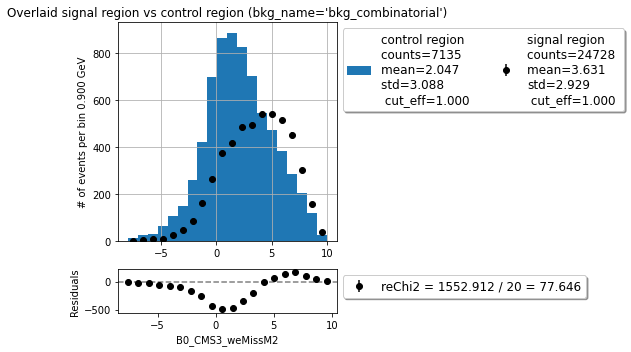

In [125]:
# compare control vs signal regions MC
b1 = np.linspace(-8,10,21)
weights = {'control region': 1,
         'signal region': 0.2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_combinatorial',
                        cut=None,
                        samples_sig=samples_sig,
                        weights=weights,correction=False,mask=[])

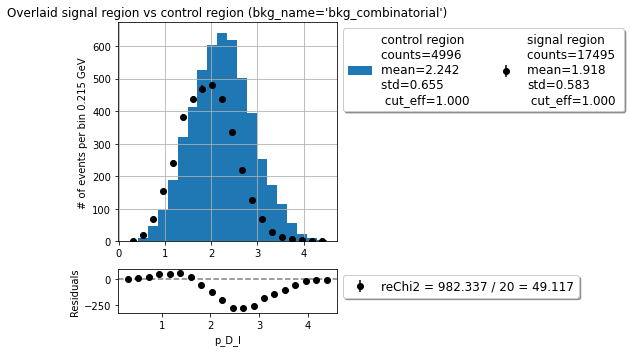

In [16]:
b2 = np.linspace(0.2,4.5,21)
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        weights=weights,correction=False,mask=[])

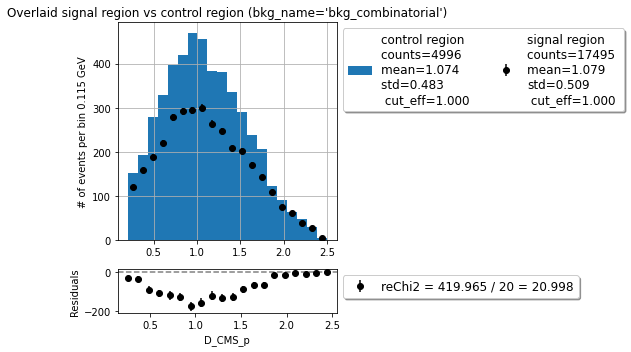

In [17]:
b2 = np.linspace(0.2,2.5,21)
mpl.plot_mc_sig_control(variable='D_CMS_p',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        weights=weights,correction=False,mask=[])

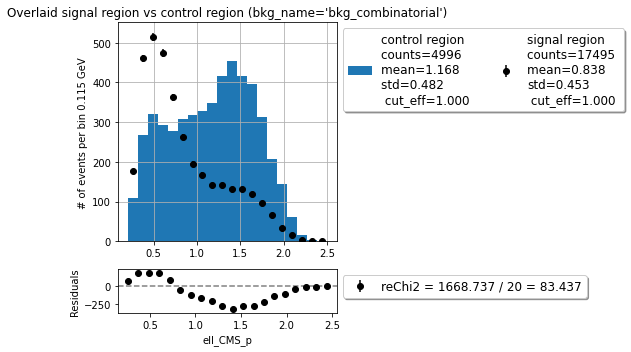

In [18]:
b2 = np.linspace(0.2,2.5,21)
mpl.plot_mc_sig_control(variable='ell_CMS_p',bins=b2,
                        bkg_name='bkg_combinatorial',cut=None,
                        samples_sig=samples_sig,
                        weights=weights,correction=False,mask=[])

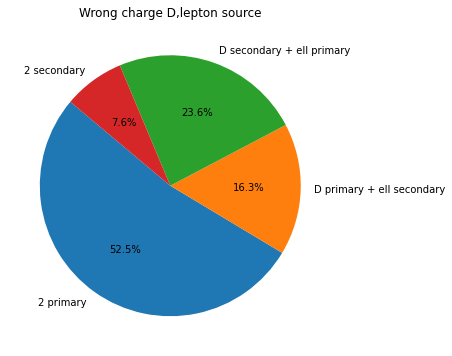

In [20]:
# Example data
sizes = [2545, 791, 1144, 367]  # Portion sizes for each component
labels = ['2 primary', 'D primary + ell secondary', 
          'D secondary + ell primary','2 secondary']  # Names of each component

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the figure
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Wrong charge D,lepton source')
plt.show()

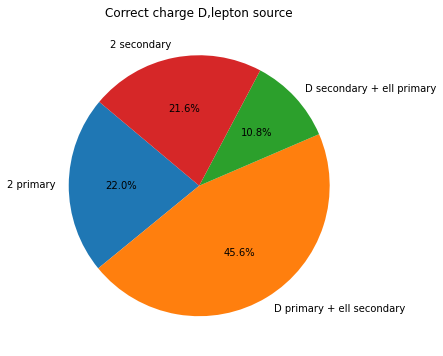

In [25]:
# Example data
sizes = [733, 1516, 359, 720]  # Portion sizes for each component
labels = ['2 primary', 'D primary + ell secondary', 
          'D secondary + ell primary','2 secondary']  # Names of each component

# Plotting the pie chart
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the figure
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Correct charge D,lepton source')
plt.show()

### Conclusion: Cannot use data driven for combinatorial bkg, WC and CC have different physics
#### Consider using MC template CC

# Check Data vs. MC

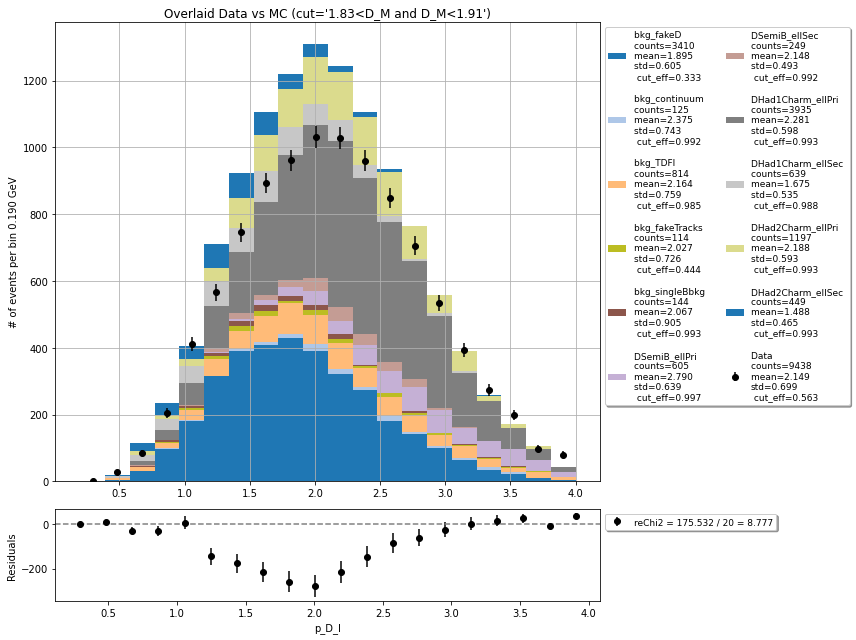

In [126]:
b2 = np.linspace(0.2,4,21)
a,b=mpl_wc.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='1.83<D_M and D_M<1.91',
                          correction=False,mask=[],figsize=(12,9),
                          legend_nc=2,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1,
                              'data':200/187})

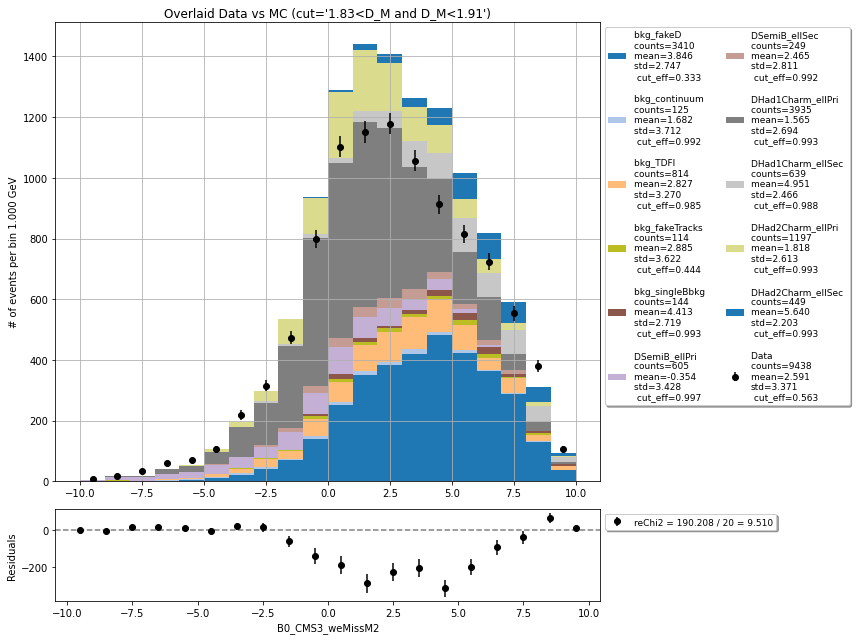

In [127]:
b1 = np.linspace(-10,10,21)
a,b=mpl_wc.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,ratio=False,
                          cut='1.83<D_M and D_M<1.91',
                          correction=False,mask=[],figsize=(12,9),
                          legend_nc=2,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1,
                              'data':200/187})

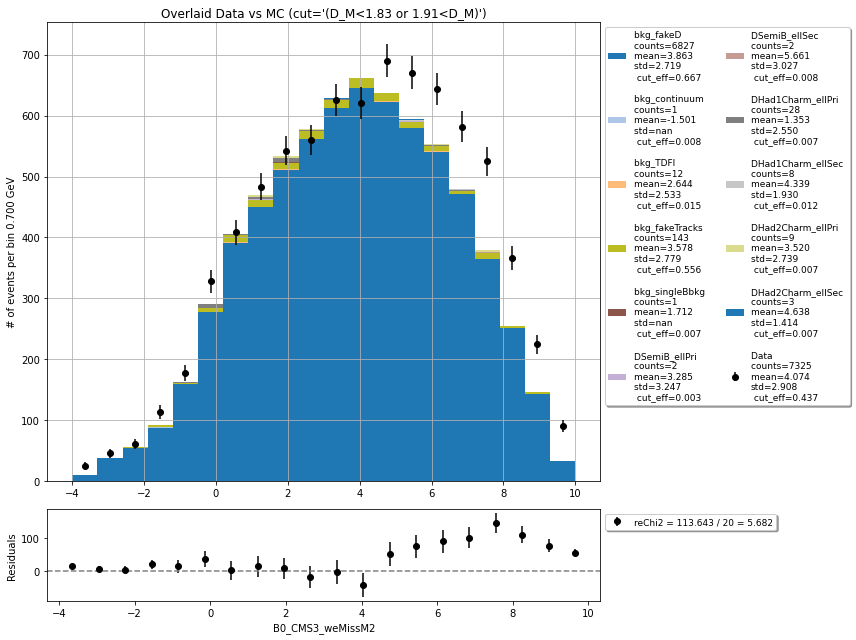

In [128]:
# sidebands
b1 = np.linspace(-4,10,21)
a,b=mpl_wc.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(12,9),
                          cut='(D_M<1.83 or 1.91<D_M)',correction=False,
                          mask=[],ratio=False,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1,
                              'data':200/187})

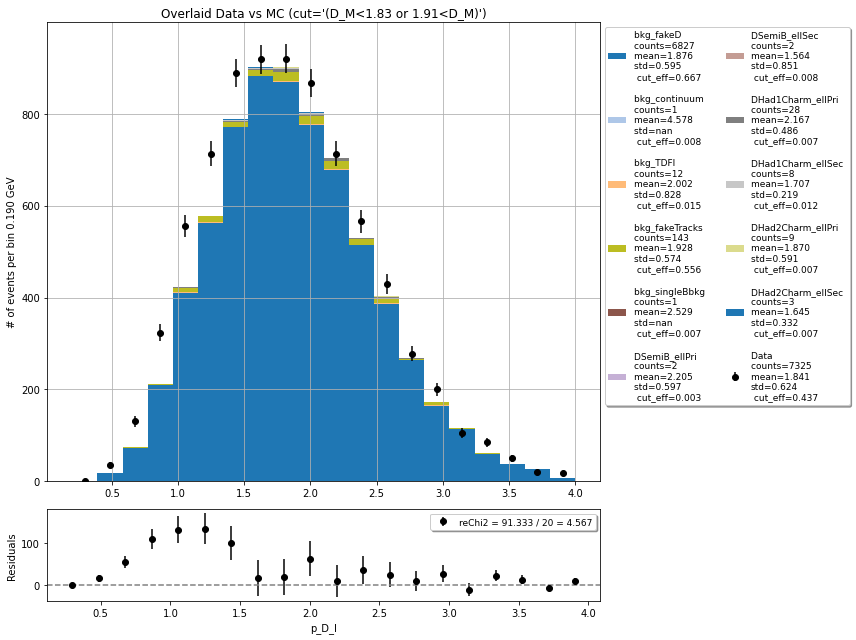

In [129]:
# sidebands
b2 = np.linspace(0.2,4,21)
a,b=mpl_wc.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,legend_fs=9,
                          cut='(D_M<1.83 or 1.91<D_M)',correction=False,mask=[],
                                figsize=(12,9), weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1,
                              'data':200/187})

# Create data driven template for FakeD
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

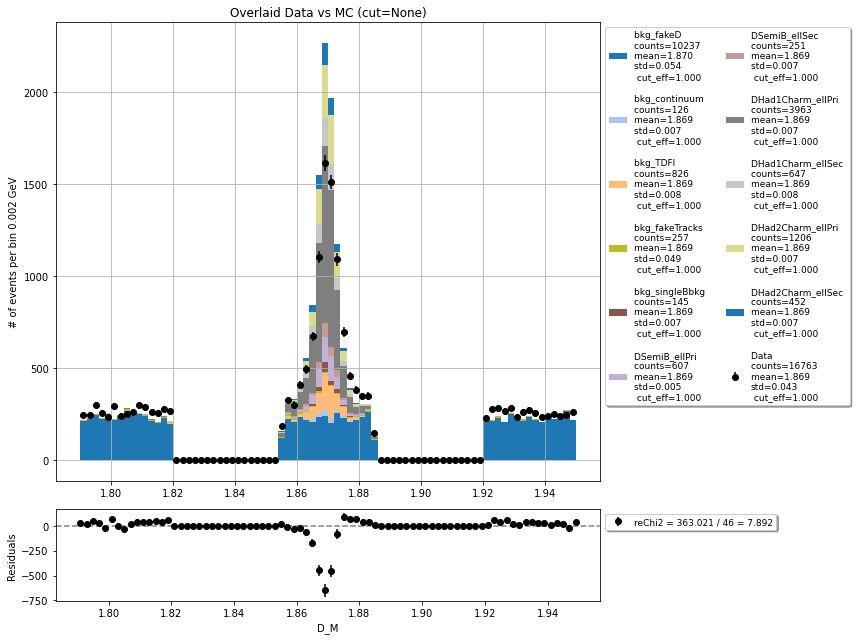

In [130]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,81)
data_hist_all, mc_hist_all = mpl_wc.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=None,correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_fs=9,weights={
                              'DSemiB_ellPri':    1,
                              'DSemiB_ellSec':    1,
                              'DHad1Charm_ellPri':1,
                              'DHad1Charm_ellSec':1,
                              'DHad2Charm_ellPri':1,
                              'DHad2Charm_ellSec':1,
                              'data':200/187})

### b. fit the FakeD with a polynomial

In [131]:
fitter = util.fit_Dmass(x_edges=b1, hist=data_hist_all, poly_only=True)

In [42]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls

initial parameters= [17.1   1.87  0.04 32.5  29.3 ]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.66 (chi2/ndof = 1.3)    │              Nfcn = 42               │
│ EDM = 3.09e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.00    │   0.17    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │    39     │    27     │            │            │         │         │       │
│ 4 │ x4   │    20     │    50     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0         0         0         0 │
│ x3 │         0         0         0       729 -1.36e+03 │
│ x4 │         0         0         0 -1.36e+03  2.55e+03 │
└────┴───────────────────────────────────────────────────┘

In [132]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml

initial parameters= [ 3.59000e+01  1.87000e+00  4.00000e-02  1.79283e+04 -7.05000e+01
  3.93100e+02]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.24 (chi2/ndof = 1.5)    │              Nfcn = 78               │
│ EDM = 5.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    0.0    │    0.4    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  40.0e-3  │  0.4e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  20.88e3  │  0.24e3   │            │            │         │         │       │
│ 4 │ x4   │  -0.06e3  │  0.21e3   │            │            │         │         │       │
│ 5 │ x5   │   0.3e3   │   1.2e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0 │
│ x2 │         0         0         0         0         0         0 │
│ x3 │         0         0         0  5.77e+04      -117      -258 │
│ x4 │         0         0         0      -117  4.37e+04 -2.43e+05 │
│ x5 │         0         0         0      -258 -2.43e+05  1.38e+06 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [133]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82 = 3982.649 ± 64.665
Yields from 1.855 to 1.885 = 3914.876 ± 45.024
Yields from 1.92 to 1.95 = 3847.104 ± 61.868


In [134]:
a = len(df_data_wc_lgb.query('1.79<D_M<1.82')) * 200/187
b = len(df_data_wc_lgb.query('1.92<D_M<1.95')) * 200/187
print('data', a,b)

data 3986.096256684492 3848.128342245989


### d. Plot and compare MC of the weighted sideband and signal region

In [135]:
(yields_sig/yields_left/2).n, (yields_sig/yields_right/2).n

(0.49149153297317794, 0.5088082456992143)

In [33]:
a = 0.491
b = 0.509

float

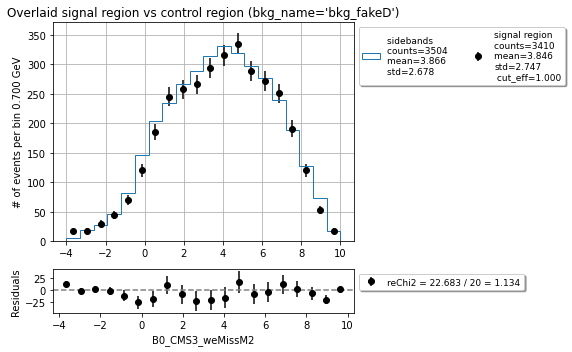

In [136]:
# showing the scaled sidebands vs. sig region from mc
b1 = np.linspace(-4,10,21)
scale = {'left sideband': (yields_sig/yields_left/2).n,
         'signal region': 1,
         'right sideband': (yields_sig/yields_right/2).n}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        weights=scale,correction=False,mask=[],legend_fs=9)

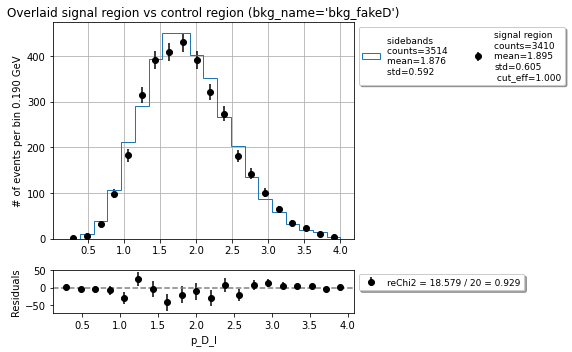

In [137]:
b2 = np.linspace(0.2,4,21)
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_fakeD',cut=None,
                        weights=scale,correction=False,mask=[],legend_fs=9)

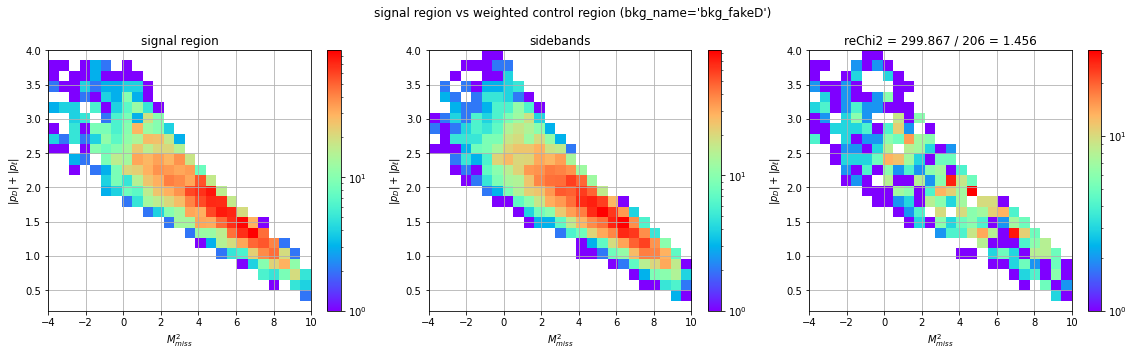

In [141]:
b1 = np.linspace(-4,10,26)
b2 = np.linspace(0.2,4,26)
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        weights=scale,correction=True,mask=[],figsize=(16,5))

## 2. Subtract the FakeD from the signal region

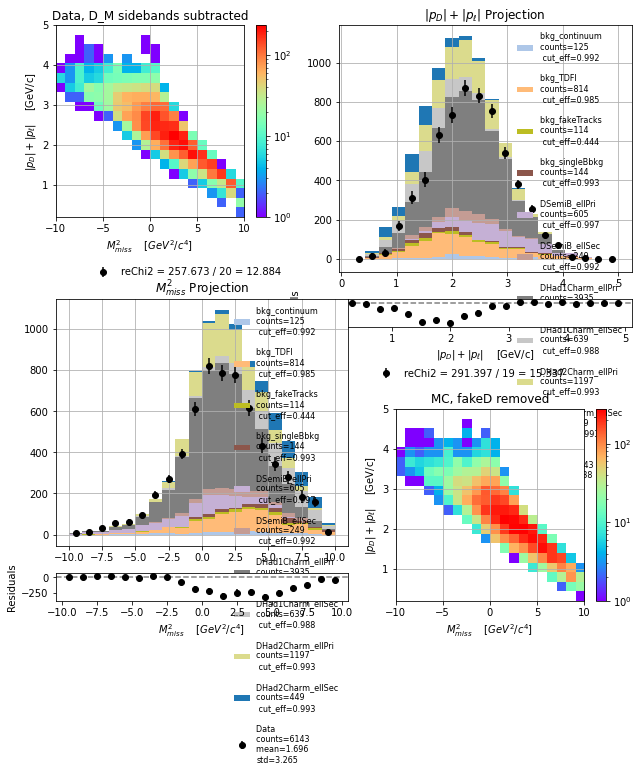

In [142]:
b_mm2 = np.linspace(-10,10,21)
b_pDl = np.linspace(0.2,5,21)
scale = {'data left sideband': 0.491 * 200/187,
         'data right sideband': 0.509 * 200/187,
         'data signal region': 200/187}

par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl_wc.plot_data_subtracted_and_mc(**par_dict)

## 3. Fit combinatorial components

In [143]:
import json
spec_wc_e = util.create_workspace(temp_asimov_channels=[temp_data],
                               mc_uncer=True,fakeD_uncer=True)
spec_wc_e['measurements'][0]['config']['poi']="DHad2Charm_ellSec_norm"
print(json.dumps(spec_wc_e, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "channel_0",
            "samples": [
                {
                    "data": [
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        1.0,
                        1.0,
                        0.0,
                        0.0,
                        5.0,
                        1.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        3.0,
                        1.0,
                        0.0,
                        1.0,
                        4.0,
                        1.0,
                        1.0,
                        4.0,
                        0.0,
                        0.0,
                        1.0,
                       

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier DHad1Charm_ellPri_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DHad1Charm_ellSec_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DHad2Charm_ellPri_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DHad2Charm_ellSec_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DSemiB_ellPri_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DSemiB_ellSec_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeTracks_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_singleBbkg_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mcStat_ch0 

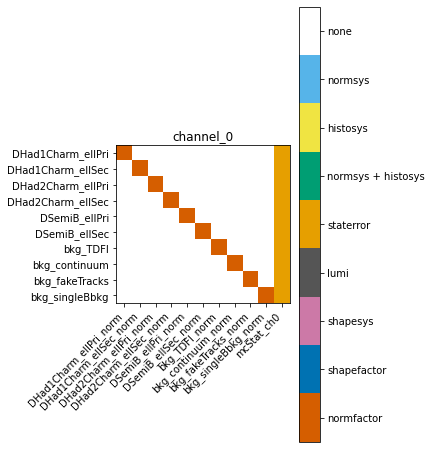

In [144]:
import cabinetry, pyhf
cabinetry.set_logging()
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec_wc_e).model())

In [145]:
model_wc, data_wc = cabinetry.model_utils.model_and_data(spec_wc_e)
pars = model_wc.config.suggested_init()

norm_parameter_names = [par for par in model_wc.config.par_order if par.endswith('_norm')]
for par in norm_parameter_names:
    model_wc.config.param_set(par).suggested_bounds=[[0,5]]

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier DHad1Charm_ellPri_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DHad1Charm_ellSec_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DHad2Charm_ellPri_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DHad2Charm_ellSec_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DSemiB_ellPri_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier DSemiB_ellSec_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeTracks_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_singleBbkg_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mcStat_ch0 

In [146]:
%%time
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_wc, data=data_wc,goodness_of_fit=True,
                                #init_pars=[1]*6+pars[6:],
                                #fix_pars=[False, False, False, True, False, True]+[True]*6
                               )

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 712.8                      │       Nfcn = 8160, Ngrad = 22        │
│ EDM = 0.00052 (Goal: 0.0002)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - mcStat_ch0[96]         =  0.7594 +/- 0.0496
INFO - cabinetry.fit - mcStat_ch0[97]         =  0.7843 +/- 0.1386
INFO - cabinetry.fit - mcStat_ch0[98]         =  0.6821 +/- 0.1821
INFO - cabinetry.fit - mcStat_ch0[99]         =  0.8515 +/- 0.0841
INFO - cabinetry.fit - mcStat_ch0[100]        =  0.8778 +/- 0.0512
INFO - cabinetry.fit - mcStat_ch0[101]        =  0.9947 +/- 0.0533
INFO - cabinetry.fit - mcStat_ch0[102]        =  1.1658 +/- 0.2434
INFO - cabinetry.fit - mcStat_ch0[103]        =  0.8432 +/- 0.1165
INFO - cabinetry.fit - mcStat_ch0[104]        =  0.9264 +/- 0.0593
INFO - cabinetry.fit - mcStat_ch0[105]        =  1.0897 +/- 0.0580
INFO - cabinetry.fit - mcStat_ch0[106]        =  1.0142 +/- 0.2030
INFO - cabinetry.fit - mcStat_ch0[107]        =  0.7617 +/- 0.0826
INFO - cabinetry.fit - mcStat_ch0[108]        =  1.1308 +/- 0.0618
INFO - cabinetry.fit - mcStat_ch0[109]        =  0.9587 +/- 0.0904
INFO - cabinetry.fit - mcStat_ch0[110]        =  1.4507 +/- 0.

CPU times: user 2.81 s, sys: 22 ms, total: 2.83 s
Wall time: 2.82 s


## 4. Apply the fit results

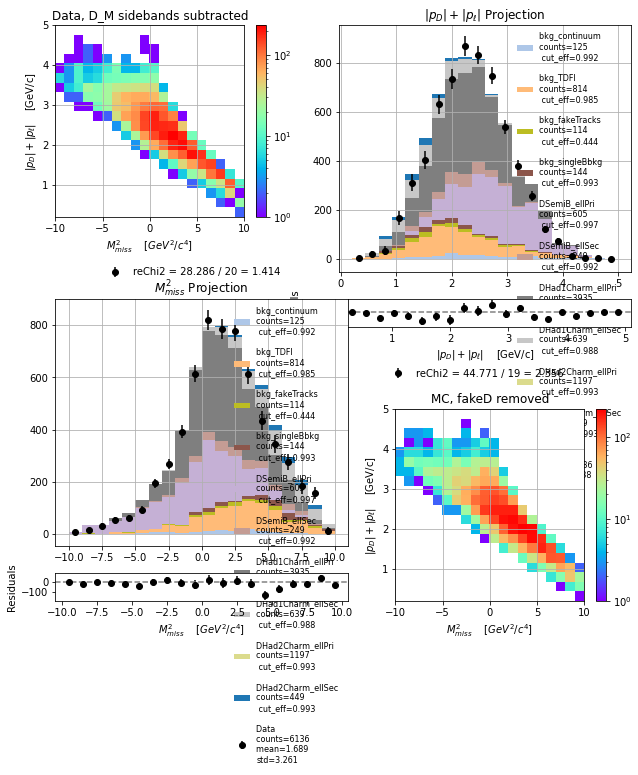

In [151]:
# BDT signal
b_mm2 = np.linspace(-10,10,21)
b_pDl = np.linspace(0.2,5,21)
weights={'data left sideband':  0.515 * 200/187,
         'data right sideband': 0.486 * 200/187,
         'data signal region':  200/187,
         'DSemiB_ellPri':       2.84,
         'DSemiB_ellSec':       1.12,
         'DHad1Charm_ellPri':   0.67,
         'DHad1Charm_ellSec':   0.81,
         'DHad2Charm_ellPri':   0,
         'DHad2Charm_ellSec':   0.27, }

par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': weights,
          'correction': False,
          'mask': ['bkg_fakeD']}
a, b = mpl_wc.plot_data_subtracted_and_mc(**par_dict)

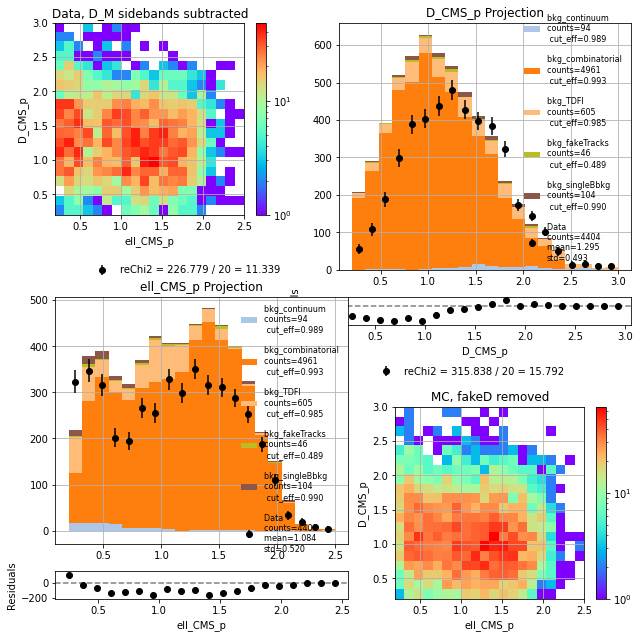

In [83]:
# BDT signal, pl; pd
b_mm2 = np.linspace(0.2,2.5,21)
b_pDl = np.linspace(0.2,3,21)
par_dict={'var_list':['ell_CMS_p','D_CMS_p'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
a,b = mpl.plot_data_subtracted_and_mc(**par_dict)

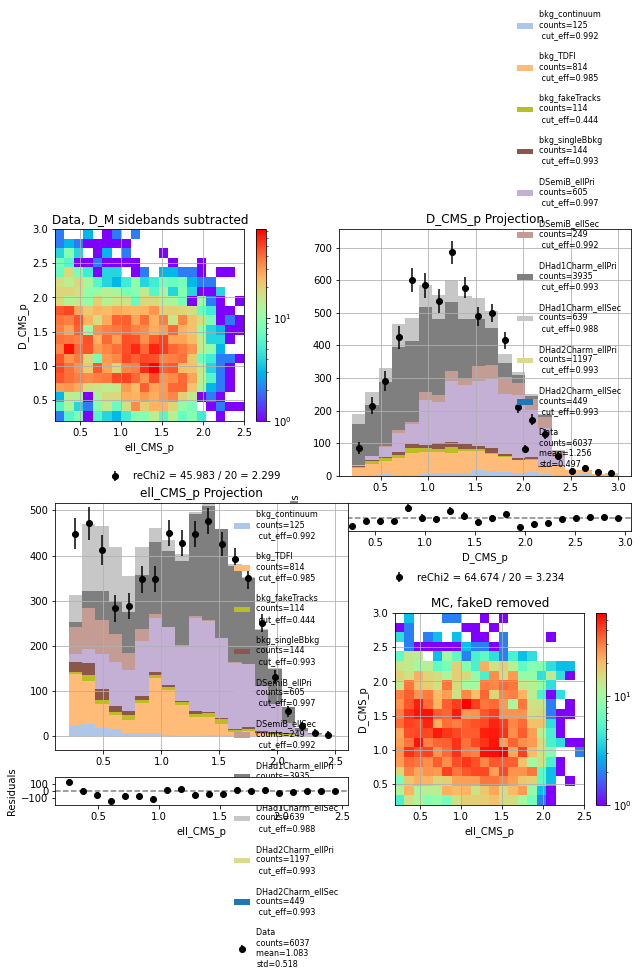

In [148]:
# BDT signal, pl; pd
b_mm2 = np.linspace(0.2,2.5,21)
b_pDl = np.linspace(0.2,3,21)
par_dict={'var_list':['ell_CMS_p','D_CMS_p'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0',
          'weights': weights,
          'correction': False,
          'mask': ['bkg_fakeD']}
a,b = mpl_wc.plot_data_subtracted_and_mc(**par_dict)

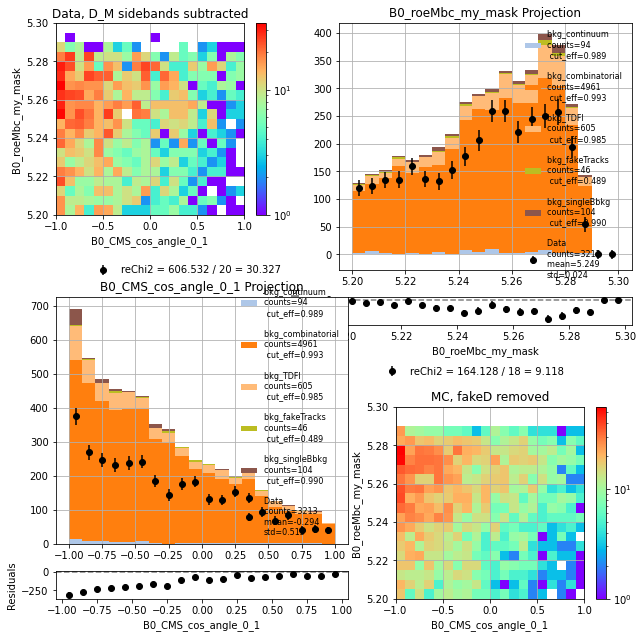

In [84]:
# BDT signal, pl; pd
b_mm2 = np.linspace(-1,1,21)
b_pDl = np.linspace(5.2,5.3,21)
par_dict={'var_list':['B0_CMS_cos_angle_0_1','B0_roeMbc_my_mask'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
a,b = mpl.plot_data_subtracted_and_mc(**par_dict)

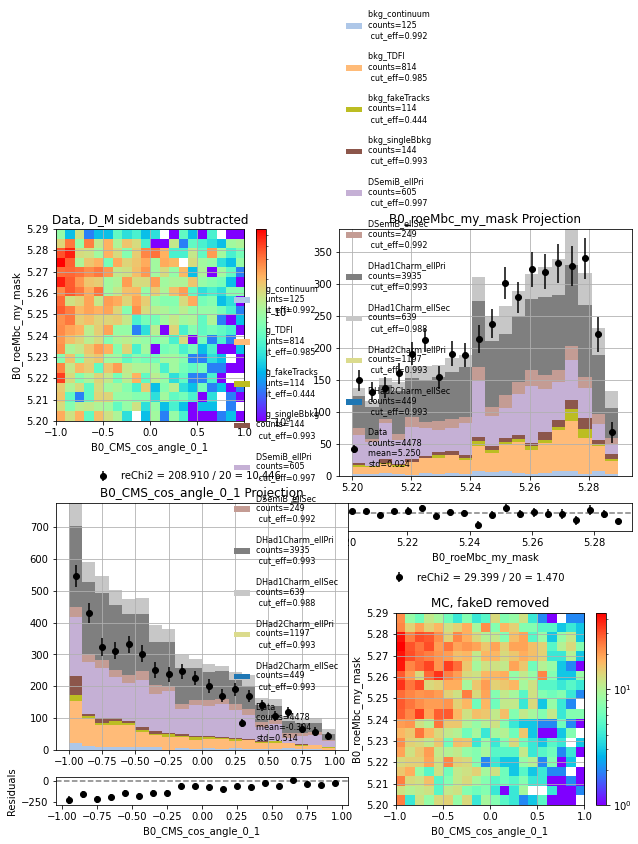

In [149]:
# BDT signal, pl; pd
b_mm2 = np.linspace(-1,1,21)
b_pDl = np.linspace(5.2,5.29,21)
par_dict={'var_list':['B0_CMS_cos_angle_0_1','B0_roeMbc_my_mask'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0',
          'weights': weights,
          'correction': False,
          'mask': ['bkg_fakeD']}
a,b = mpl_wc.plot_data_subtracted_and_mc(**par_dict)